In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.optimize import curve_fit
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import itertools
import os
import scipy
import pickle

# Prepare Data

In [ ]:
df = pd.read_csv("erdos_renyi_a-g_with_graph_features.csv")

In [ ]:
# List of predictors
predictors = ['p', 'Number of vertices', 'Number of edges', 'Edge density',
       'Mean degree', 'Standard deviation of degrees', 'Skewness of degrees',
       'Minimum degree', 'Maximum degree', 'Diameter', 'Radius',
       'Vertex connectivity', 'Edge connectivity',
       'Global clustering coefficient', 'Mean local clustering coefficient',
       'Standard deviation of local clustering coefficients',
       'Skewness of local clustering coefficients',
       'Minimum local clustering coefficient',
       'Maximum local clustering coefficient', 'Treewidth',
       'Average path length', 'Circuit rank', 'Girth',
       'Mean betweenness centrality',
       'Standard deviation of betweenness centralities',
       'Skewness of betweenness centralities',
       'Minimum betweenness centrality', 'Maximum betweenness centrality',
       'Algebraic connectivity', 'Von Neumann entropy',
       'Adjacency spectrum mean', 'Adjacency spectrum standard deviation',
       'Adjacency spectrum skewness', 'Adjacency spectrum min',
       'Adjacency spectrum max', 'Laplacian spectrum mean',
       'Laplacian spectrum standard deviation', 'Laplacian spectrum skewness',
       'Laplacian spectrum max', 'Planarity',
       'Mean harmonic centrality',
       'Standard deviation of harmonic centralities',
       'Skewness of harmonic centralities', 'Minimum harmonic centrality',
       'Maximum harmonic centrality', 'Harmonic diameter', 'Mean core number',
       'Standard deviation of core numbers', 'Skewness of core numbers',
       'Minimum core number', 'Maximum core number', 'Chordality',
       'Haemers bound', 'Claw-free']

In [ ]:
# Split df into training and testing dataset (ratio of 80:20)
df_y = df['f_calls']
df_x = df[predictors]
train_x, test_x, train_y, test_y = train_test_split(df_x, df_y, test_size=.2)

We follow the preprocessing framework outlined on page 13 of Empirical Hardness Models: Methodology and a Case Study on Combinatorial Auctions (Kevin Leyton-Brown et al.)

In [ ]:
def preprocessing(train_x, test_x, train_y, test_y, predictors):
  feature_to_remove = ""
  max = 0
  N = len(test_x)
  p = len(predictors) - 1

  for feature in predictors:
    linear_regression_model = linear_model.LinearRegression()
    new_predictors = predictors.copy()
    new_predictors.remove(feature)

    linear_regression_model.fit(train_x[new_predictors], train_x[feature])
    linear_regression_predictions = linear_regression_model.predict(test_x[new_predictors])

    r2 = r2_score(test_x[feature], linear_regression_predictions)
    adj_r2 = 1 - (1 - r2) * ((N - 1)/(N - p - 1))

    # paper uses threshold of τ = 0.99999 (pg 24)
    if (adj_r2 >= .99999 and adj_r2 > max and r2 >= 0):
      max = adj_r2
      feature_to_remove = feature

  return feature_to_remove

feature_to_remove = preprocessing(train_x, test_x, train_y, test_y, predictors)

while (feature_to_remove != ""):
  predictors.remove(feature_to_remove)
  feature_to_remove = preprocessing(train_x, test_x, train_y, test_y, predictors)

train_x = train_x[predictors]
test_x = test_x[predictors]

Using the feature importance table from the random forest regression, we identified the least important features when predicting the number of calls to the quantum circuit and removed them from the list of predictors when using random forest regression to predict the number of calls to the quantum circuit.

In [ ]:
features_rfr_calls = predictors.copy()
features_to_remove = ['Maximum degree', 'Maximum core number',
                     'Minimum core number', 'Edge connectivity',
                     'Number of vertices', 'Claw-free', 'Diameter',
                     'Vertex connectivity', 'Radius', 'Planarity',
                     'Girth', 'Chordality']

for feature in features_to_remove:
    if feature in features_rfr_calls:
        features_rfr_calls.remove(feature)

# Random Forest Regression Implementation

In random forest regression, an ensemble of decision trees are randomly created. The final prediction of the model is computed by taking the mean of the predictions of each decision tree. By taking the mean of several decision trees, random forest reduces the risk of overfitting while still being able to model complicated relationships.

In [ ]:
# Train & test random forest regression model
random_forest_regression_model = RandomForestRegressor()
random_forest_regression_model.fit(train_x[new_features], train_y)
random_forest_regression_predictions = random_forest_regression_model.predict(test_x[new_features])

print("Accuracy on test data: {:.3f}".format(random_forest_regression_model.score(test_x[new_features], test_y)))

Accuracy on test data: -0.889


In [ ]:
# Save model
with open('random_forest_regression_model.pkl', 'wb') as file:
  pickle.dump(random_forest_regression_model, file)

In [ ]:
# Compute & save feature importance table
importances = random_forest_regression_model.feature_importances_
feature_importance_df = pd.Series(importances, index=train_x[new_features].columns).sort_values(ascending=False)
feature_importance_df.to_csv('feature_importance_mvg.csv')

In [ ]:
# Compute accuracy of random forest regression model: RMSE, MAE, R^2, & Adj. R^2
rmse = np.sqrt(np.mean((random_forest_regression_predictions - test_y) ** 2))
mae = np.mean(np.abs(random_forest_regression_predictions - test_y))
r_2 = r2_score(np.array(test_y), random_forest_regression_predictions)
n = len(test_x)
p = len(predictors)
adj_r2 = 1 - (1 - r_2) * (n - 1)/(n - p - 1)

print("RMSE: {:.3f}".format(rmse)) # minimize
print("MAE: {:.3f}".format(mae)) # minimize
print("R^2: {:.3f}".format(r_2)) # close to 1
print("Adj. R^2: {:.3f}".format(adj_r2)) # close to 1

RMSE: 472.651
MAE: 186.915
R^2: 0.906
Adj. R^2: 0.904


In [ ]:
# View predicted vs. actual results for ridge regression model
predicted_df = pd.DataFrame(random_forest_regression_predictions, columns=["Predicted"], index=test_x.index) # pd.DataFrame(random_forest_regression_model.predict(test_x[predictors]), columns=["Predicted"], index=test_x.index)
rfr_comparison = pd.concat([predicted_df, test_y], axis=1)
rfr_comparison

,Predicted,mean_grad_variance
1744,12922.370654,9736.238000
1745,2898.180026,2523.282036
1746,717.608610,500.256067
1747,263.662167,88.568401
1748,6186.093697,3999.172233
...,...,...
23287,841.197696,875.926115
23288,15707.381521,18170.589993
23289,2865.514679,2839.067609
23290,819.385125,893.834928


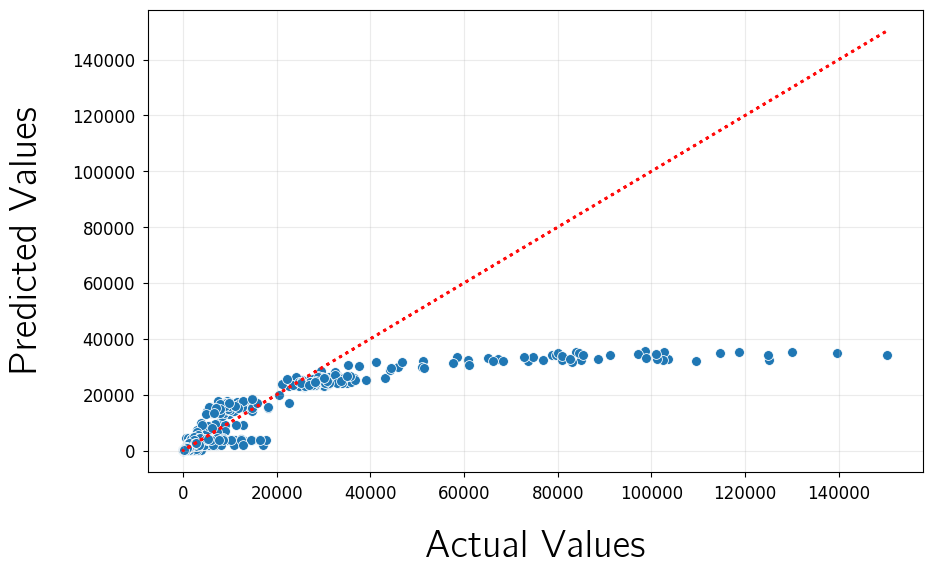

In [ ]:
# Graph predicted vs. actual results for random forest regression model
font_prop = fm.FontProperties(fname='cmunbmr.ttf')

with plt.style.context('seaborn-v0_8-paper'):
  plt.figure(figsize=(10, 6))
  sns.scatterplot(x=rfr_comparison['mean_grad_variance'], y=rfr_comparison['Predicted'], s=50)
  plt.plot(test_y, test_y, color='#FF0C0C', linestyle='dotted', linewidth=2)

  plt.xlabel('Actual Values', fontsize=27, fontproperties=font_prop, labelpad=20)
  plt.ylabel('Predicted Values', fontsize=27, fontproperties=font_prop, labelpad=20)
  plt.grid(True, alpha=.25)
  plt.tick_params(axis='both', labelsize=12)
  plt.show()